# Recombine blocks the Rydberg Hamiltonian into given number of threads

This uses the standard "multiprocessor scheduling algorithm" to balance the operator sizes as much as possible, but makes the operators quite disjunct.

In [1]:
from pathlib import Path

In [2]:
import qutip
import numpy as np
import matplotlib.pylab as plt
import scipy.sparse

In [3]:
from src.qdyn.io import read_indexed_matrix
from src.qdyn.model import LevelModel
from src.qdyn.pulse import Pulse
from src.plots import show_spy, plot_population
from src.blocksplitting import split_AB, split_AB_blocks
from src.ham import rydberg_hamiltonian

In [4]:
%matplotlib inline

In [5]:
V_per_cm = 1.0 / 5.14220624463189208e09

In [6]:
# 1-based indices of the initial and target states
N_INITIAL = 1423
N_TARGET = 2696
# size of Hilbert space
N_HILBERT = N_TARGET
N_THREADS = 12  # number of cores on the machine

In [7]:
H = rydberg_hamiltonian(
    N_HILBERT,
    'data/ham_drift.dat',
    'data/ham_sig.dat',
    'data/ham_pi.dat',
    F_DC=2.5 * V_per_cm,
    Omega_sigma=Pulse.read('./data/pulse_sig.dat')
)

In [8]:
psi0 = qutip.ket([N_INITIAL-1], dim=H[0].shape[0])
psi_target = qutip.ket([N_TARGET-1], dim=H[0].shape[0])

In [9]:
A, B = split_AB_blocks(
    H[1][0].data,
    block_info=np.genfromtxt("./data/n_states_red_block.dat", dtype=np.int32),
    n=N_HILBERT,
    as_qobj=True,
)

In [10]:
def distribute_zigzag(list_of_blocks, n_threads):
    """Standard Multiprocessor scheduling algorithm"""
    thread_bins = [[] for _ in range(n_threads)]
    thread_filled = np.array([0 for _ in range(n_threads)])
    sorted_list_of_blocks = sorted(
        list_of_blocks, key=lambda block: block.data.nnz, reverse=True
    )
    for block in sorted_list_of_blocks:
        i_thread = np.argmin(thread_filled)
        thread_bins[i_thread].append(block)
        thread_filled[i_thread] += block.data.nnz
    return thread_bins

In [11]:
A_thread_bins = distribute_zigzag(A, N_THREADS)

In [12]:
[sum(op.data.nnz for op in bin) for bin in A_thread_bins]

[3854, 3853, 3865, 3856, 3850, 3876, 3856, 3864, 3854, 3862, 3906, 3956]

In [13]:
A_thread_ops = [sum(bin) for bin in A_thread_bins]

In [14]:
B_thread_bins = distribute_zigzag(B, N_THREADS-1)

In [15]:
[sum(op.data.nnz for op in bin) for bin in B_thread_bins]

[4214, 4203, 4231, 4204, 4210, 4240, 4254, 4204, 4240, 4220, 4232]

In [16]:
B_thread_ops = [sum(bin) for bin in B_thread_bins]

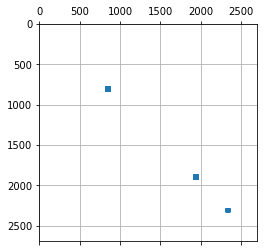

In [17]:
show_spy(A_thread_ops[11].data, show_diagonal=False, grid=True)

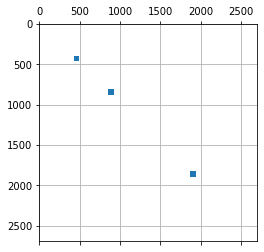

In [18]:
show_spy(B_thread_ops[10].data, show_diagonal=False, grid=True)

In [19]:
qdyn_model = LevelModel()

In [20]:
qdyn_model.add_ham(H[0], op_unit='au', op_type='pot')

In [21]:
for op in A_thread_ops:
    qdyn_model.add_ham(op, pulse=H[1][1], op_unit='au', op_type='dip')

In [22]:
for op in B_thread_ops:
    qdyn_model.add_ham(op, pulse=H[1][1], op_unit='au', op_type='dip')

In [23]:
for op in A_thread_ops:
    qdyn_model.add_ham(op.dag(), pulse=H[1][1], op_unit='au', op_type='dip', conjg_pulse=True)

In [24]:
for op in B_thread_ops:
    qdyn_model.add_ham(op.dag(), pulse=H[1][1], op_unit='au', op_type='dip', conjg_pulse=True)

In [25]:
qdyn_model.add_state(psi0, label='initial')

In [26]:
qdyn_model.add_state(psi_target, label='target')

In [27]:
qdyn_model.add_observable(
    qutip.ket2dm(psi0),
    'population.dat',
    exp_unit='iu',
    time_unit='ns',
    col_label='initial',
)
qdyn_model.add_observable(
    qutip.ket2dm(psi_target),
    'population.dat',
    exp_unit='iu',
    time_unit='ns',
    col_label='target',
)

In [28]:
qdyn_model.set_propagation(
    T=H[1][1].T,
    nt=len(H[1][1].states_tgrid),
    time_unit=H[1][1].time_unit,
)

In [29]:
RF = './rf_AB_recombined_zigzag_prop'

In [30]:
qdyn_model.write_to_runfolder(RF)

In [31]:
%%bash -s "$RF"
qdyn_prop_traj --version
time OMP_NUM_THREADS=1 qdyn_prop_traj --state-label=initial $1

QDYN 2.0dev revision 92024cace7e6b85565d01814a0de5f5cc9ae8167 (rydbergparallel)
  features: no-check-cheby, no-check-newton, no-parallel-ham, use-mkl=sequential, parallel-oct, backtraces, no-debug, no-no-ipo
  compiled with ifort on Wed Aug 21 19:45:26 2019 on host katamon
***** START OF PROGRAM qdyn_prop_traj ******
Wed Aug 21 20:33:47 +0200 2019

*** Read config file ./rf_AB_recombined_zigzag_prop/config ***
*** Done reading config file ***
*** Initializing system ***
  *** Initializing grid ***
  No explicit grid found in config file! Initializing grid as one dimensional 1x1 fake grid
    Initializing grid as 1D cartesian grid without mapping
      Number of grid points was set to nr = 1 for dimension dim = 1! Initializing dimension 1 as a 1x1 fake-grid...
  *** Initializing pulses ***
    1 pulses in config file
    Initializing pulse 1
  *** Initializing dynamical generator ***
*** Done with initialization ***

Completed traj 1/1 in proc 1/1
Writing avg in proc 1/1

Wed Aug 21 20:

1

real	3m30.045s
user	3m29.912s
sys	0m0.132s


In [32]:
pop_data = np.genfromtxt((Path(RF) / 'population.dat')).transpose()

In [33]:
pop_data_baseline = np.genfromtxt('./rf_baseline/population.dat').transpose()

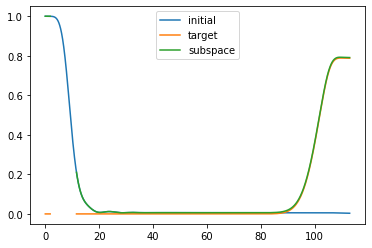

In [34]:
plot_population(pop_data)